# Experiment: Varying N in top-N DDA fragmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import sys
from collections import defaultdict
import seaborn as sns

In [3]:
sys.path.append('../codes')

In [4]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

### Useful functions

Performance is calculated by the proportion of original input peaks that got fragmented for varying values of `N` and `rt_tol`. More is better.

In [5]:
def find_chem(to_find, chem_list):
    for chem in chem_list:
        if chem.max_intensity == to_find.max_intensity and \
            chem.rt == to_find.rt and \
            chem.chromatogram == to_find.chromatogram:
            return chem
    return None

In [6]:
def count_fragmented(chem, fragmented_chems):
    peaks = fragmented_chems[chem]
    ms_counts = defaultdict(int)
    for p in peaks:
        ms_counts[p.ms_level] += 1
    return ms_counts

In [7]:
def compute_performance(controller, dataset):
    positives = list(filter(lambda x: x.type == 'data', dataset))
    negatives = list(filter(lambda x: x.type == 'noise', dataset))

    # count the following:
    # true positive = is a real data and is fragmented
    # false positive = is not a real data but is fragmented
    # false negative = is a real data but is not fragmented
    tp = 0
    fp = 0
    seen = set()
    fragmented_chems = controller.mass_spec.chemicals_to_peaks
    for i in range(len(dataset)):
#         if i % 1000 == 0:
#             print('%d/%d' % (i, len(dataset)))
        chem = dataset[i]
        found = find_chem(chem, fragmented_chems)
        if found:
            ms_counts = count_fragmented(found, fragmented_chems)
            if ms_counts[2] > 0: 
                if found.type == 'data':
                    tp += 1
                    seen.add(chem)
                elif found.type == 'noise':
                    fp += 1

    false_negatives = [chem for chem in positives if chem not in seen]
    fn = len(false_negatives)
    
    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = ( 2 * prec * rec) / (prec + rec)
    prec, rec, f1
    
    print('tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (tp, fp, fn, prec, rec, f1))
    return tp, fp, fn, prec, rec, f1

In [8]:
def load_controller(N, rt_tol):
    analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
    pickle_in = '%s/%s.p' % (results_dir, analysis_name) 
    print('Loading %s' % analysis_name)                    
    try:
        controller = load_obj(pickle_in)
    except FileNotFoundError:
        controller = None
    return controller

### Load experiment results

In [9]:
results_dir = '../models/noisy_dda_results'

In [10]:
dataset = load_obj('%s/noisy_dataset.p' % results_dir)

In [11]:
Ns = list(range(2, 51, 2)) # top-N DDA fragmentation
rt_tols = list(range(5, 31, 5)) # the rt window around a selected precursor ion to prevent it from fragmented multiple times

### Compute performance

In [12]:
%matplotlib inline

Fixed N = 10 and varying rt_tols

In [13]:
N = 10
results = []
for rt_tol in rt_tols:
    controller = load_controller(N, rt_tol)
    if controller is not None:
         res = (N, rt_tol) + compute_performance(controller, dataset)            
    results.append(res)

Loading experiment_N_10_rttol_5
tp=1228 fp=749 fn=8596 prec=0.621 rec=0.125 f1=0.208
Loading experiment_N_10_rttol_10
tp=1155 fp=616 fn=8669 prec=0.652 rec=0.118 f1=0.199
Loading experiment_N_10_rttol_15
tp=1067 fp=524 fn=8757 prec=0.671 rec=0.109 f1=0.187
Loading experiment_N_10_rttol_20
tp=985 fp=480 fn=8839 prec=0.672 rec=0.100 f1=0.175
Loading experiment_N_10_rttol_25
tp=922 fp=442 fn=8902 prec=0.676 rec=0.094 f1=0.165
Loading experiment_N_10_rttol_30
tp=874 fp=423 fn=8950 prec=0.674 rec=0.089 f1=0.157


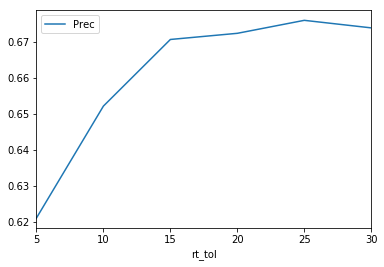

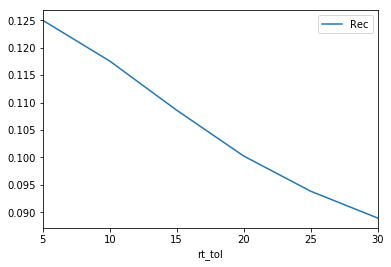

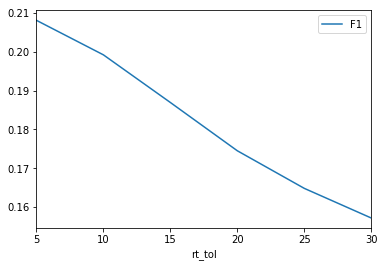

In [14]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])
df.plot.line(x='rt_tol', y=['Prec'])
df.plot.line(x='rt_tol', y=['Rec'])
df.plot.line(x='rt_tol', y=['F1'])

Fixed rt_tol = 15 and varying Ns

In [15]:
rt_tol = 15
results = []
for N in Ns:
    controller = load_controller(N, rt_tol)
    if controller is not None:
         res = (N, rt_tol) + compute_performance(controller, dataset)            
    results.append(res)

Loading experiment_N_2_rttol_15
tp=279 fp=124 fn=9545 prec=0.692 rec=0.028 f1=0.055
Loading experiment_N_4_rttol_15
tp=520 fp=252 fn=9304 prec=0.674 rec=0.053 f1=0.098
Loading experiment_N_6_rttol_15
tp=713 fp=364 fn=9111 prec=0.662 rec=0.073 f1=0.131
Loading experiment_N_8_rttol_15
tp=880 fp=452 fn=8944 prec=0.661 rec=0.090 f1=0.158
Loading experiment_N_10_rttol_15
tp=1067 fp=524 fn=8757 prec=0.671 rec=0.109 f1=0.187
Loading experiment_N_12_rttol_15
tp=1215 fp=625 fn=8609 prec=0.660 rec=0.124 f1=0.208
Loading experiment_N_14_rttol_15
tp=1412 fp=723 fn=8412 prec=0.661 rec=0.144 f1=0.236
Loading experiment_N_16_rttol_15
tp=1566 fp=824 fn=8258 prec=0.655 rec=0.159 f1=0.256
Loading experiment_N_18_rttol_15
tp=1732 fp=928 fn=8092 prec=0.651 rec=0.176 f1=0.277
Loading experiment_N_20_rttol_15
tp=1863 fp=1004 fn=7961 prec=0.650 rec=0.190 f1=0.294
Loading experiment_N_22_rttol_15
tp=2024 fp=1077 fn=7800 prec=0.653 rec=0.206 f1=0.313
Loading experiment_N_24_rttol_15
tp=2156 fp=1157 fn=7668 pre

In [16]:
df

,N,rt_tol,TP,FP,FN,Prec,Rec,F1
0,10,5,1228,749,8596,0.621143,0.125000,0.208118
1,10,10,1155,616,8669,0.652174,0.117569,0.199224
2,10,15,1067,524,8757,0.670647,0.108612,0.186947
3,10,20,985,480,8839,0.672355,0.100265,0.174506
4,10,25,922,442,8902,0.675953,0.093852,0.164819
5,10,30,874,423,8950,0.673863,0.088966,0.157180


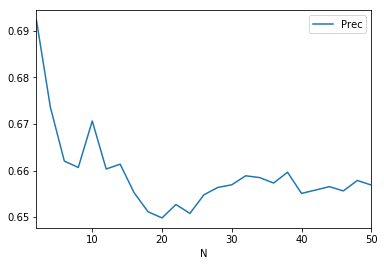

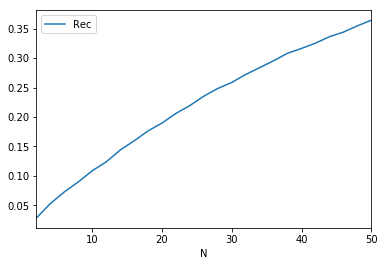

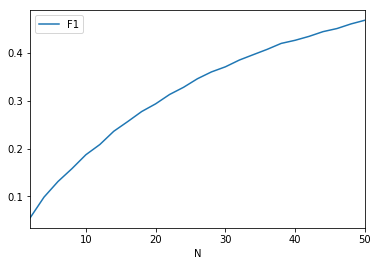

In [17]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])
df.plot.line(x='N', y=['Prec'])
df.plot.line(x='N', y=['Rec'])
df.plot.line(x='N', y=['F1'])

### Compute performance for varying Ns and rt_tols

In [19]:
X, Y = np.meshgrid(Ns, rt_tols)
Z_precision = np.zeros_like(X).astype(float)
Z_recall = np.zeros_like(X).astype(float)
Z_f1 = np.zeros_like(X).astype(float)

In [21]:
for j in range(X.shape[1]):
    for i in range(X.shape[0]):    
        N = X[i, j]
        rt_tol = Y[i, j]            
        analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
        pickle_in = '%s/%s.p' % (results_dir, analysis_name) 

        print('Loading %s' % analysis_name)                    
        try:
            controller = load_obj(pickle_in)
        except FileNotFoundError:
            controller = None

        # compute performance
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)
            Z_precision[i, j] = prec
            Z_recall[i, j] = rec
            Z_f1[i, j] = f1

Loading experiment_N_2_rttol_5
tp=332 fp=168 fn=9492 prec=0.664 rec=0.034 f1=0.064
Loading experiment_N_2_rttol_10
tp=309 fp=139 fn=9515 prec=0.690 rec=0.031 f1=0.060
Loading experiment_N_2_rttol_15
tp=279 fp=124 fn=9545 prec=0.692 rec=0.028 f1=0.055
Loading experiment_N_2_rttol_20
tp=269 fp=118 fn=9555 prec=0.695 rec=0.027 f1=0.053
Loading experiment_N_2_rttol_25
tp=255 fp=117 fn=9569 prec=0.685 rec=0.026 f1=0.050
Loading experiment_N_2_rttol_30
tp=247 fp=108 fn=9577 prec=0.696 rec=0.025 f1=0.049
Loading experiment_N_4_rttol_5
tp=608 fp=347 fn=9216 prec=0.637 rec=0.062 f1=0.113
Loading experiment_N_4_rttol_10
tp=573 fp=298 fn=9251 prec=0.658 rec=0.058 f1=0.107
Loading experiment_N_4_rttol_15
tp=520 fp=252 fn=9304 prec=0.674 rec=0.053 f1=0.098
Loading experiment_N_4_rttol_20
tp=481 fp=231 fn=9343 prec=0.676 rec=0.049 f1=0.091
Loading experiment_N_4_rttol_25
tp=469 fp=221 fn=9355 prec=0.680 rec=0.048 f1=0.089
Loading experiment_N_4_rttol_30
tp=438 fp=204 fn=9386 prec=0.682 rec=0.045 f1=

tp=2149 fp=1031 fn=7675 prec=0.676 rec=0.219 f1=0.331
Loading experiment_N_34_rttol_5
tp=3081 fp=1940 fn=6743 prec=0.614 rec=0.314 f1=0.415
Loading experiment_N_34_rttol_10
tp=3036 fp=1661 fn=6788 prec=0.646 rec=0.309 f1=0.418
Loading experiment_N_34_rttol_15
tp=2788 fp=1446 fn=7036 prec=0.658 rec=0.284 f1=0.397
Loading experiment_N_34_rttol_20
tp=2569 fp=1286 fn=7255 prec=0.666 rec=0.262 f1=0.376
Loading experiment_N_34_rttol_25
tp=2419 fp=1179 fn=7405 prec=0.672 rec=0.246 f1=0.360
Loading experiment_N_34_rttol_30
tp=2239 fp=1070 fn=7585 prec=0.677 rec=0.228 f1=0.341
Loading experiment_N_36_rttol_5
tp=3150 fp=1995 fn=6674 prec=0.612 rec=0.321 f1=0.421
Loading experiment_N_36_rttol_10
tp=3153 fp=1707 fn=6671 prec=0.649 rec=0.321 f1=0.429
Loading experiment_N_36_rttol_15
tp=2904 fp=1514 fn=6920 prec=0.657 rec=0.296 f1=0.408
Loading experiment_N_36_rttol_20
tp=2670 fp=1326 fn=7154 prec=0.668 rec=0.272 f1=0.386
Loading experiment_N_36_rttol_25
tp=2515 fp=1242 fn=7309 prec=0.669 rec=0.256 

### Make plot

In [22]:
plot_data = {
    'X': X,
    'Y': Y,
    'Z_precision': Z_precision,
    'Z_recall': Z_recall,
    'Z_f1': Z_f1
}

In [23]:
save_obj(plot_data, results_dir + '/plot_data.p')

In [24]:
def make_plot(X, Y, Z, xlabel, ylabel, zlabel, title):
    # Plot the surface.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [39]:
%matplotlib notebook

<IPython.core.display.Javascript object>


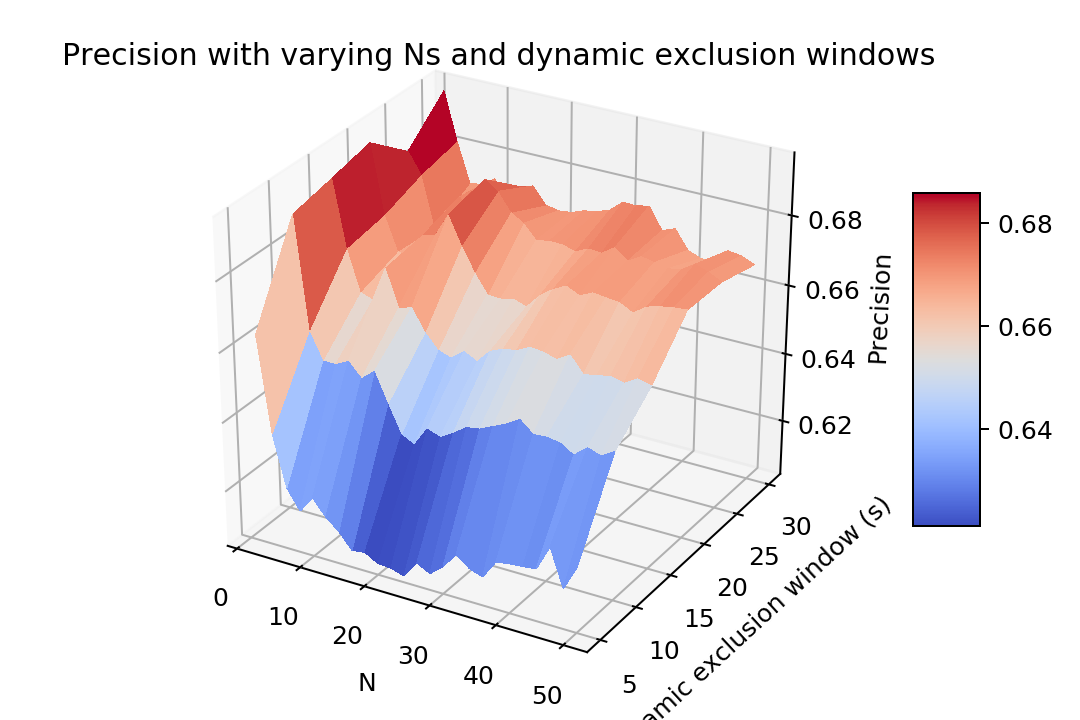

In [40]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

<IPython.core.display.Javascript object>


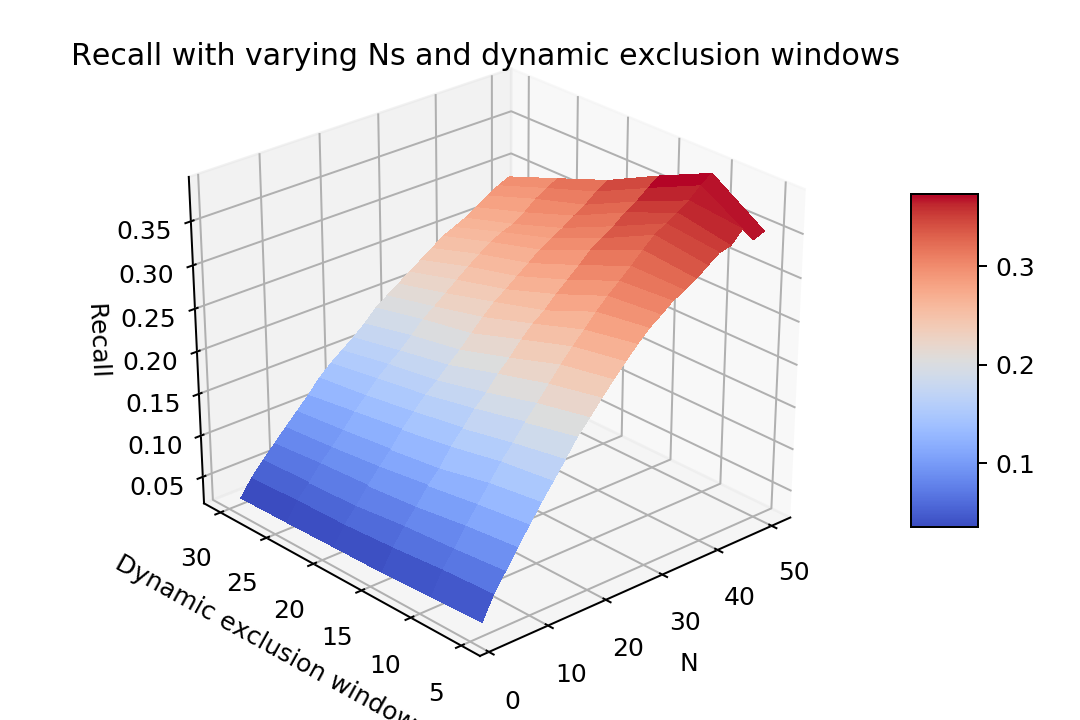

In [33]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

<IPython.core.display.Javascript object>


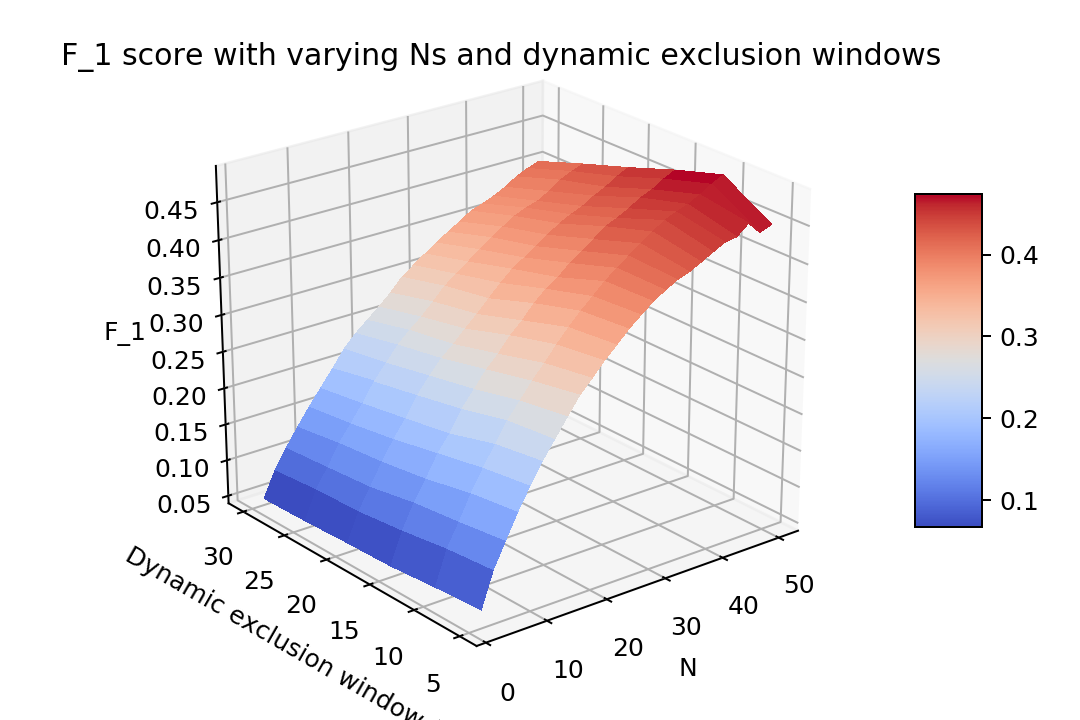

In [32]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')

In [41]:
%matplotlib inline

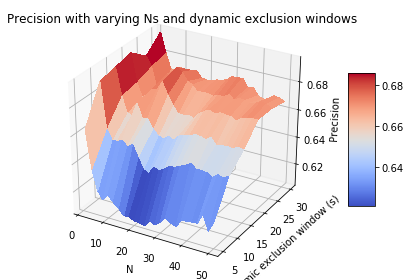

In [36]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

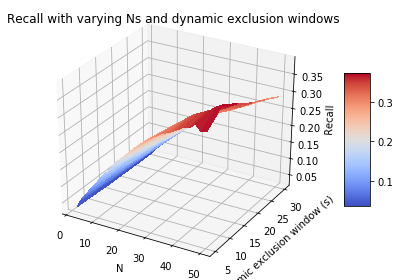

In [37]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

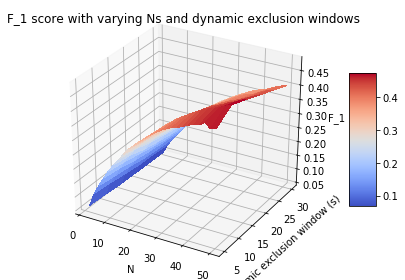

In [38]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')